<a href="https://colab.research.google.com/github/erichans/modularity-maximization/blob/main/Modularity_Maximization_Hybrid_Bat_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity
# from networkx.linalg.graphmatrix import adjacency_matrix
import matplotlib.pyplot as plt
import numpy as np
 
G = nx.karate_club_graph()

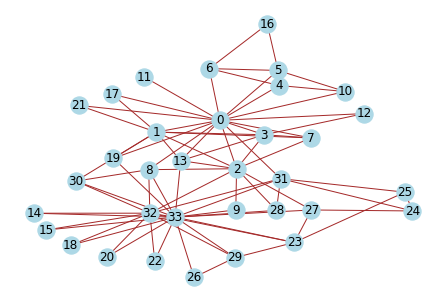

In [ ]:
nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color='lightblue', edge_color='brown', with_labels=True)

In [ ]:
c = list(greedy_modularity_communities(G))
print(f'Found {len(c)} communities: \n{sorted(c)}')

Found 3 communities: 
[frozenset({32, 33, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}), frozenset({1, 2, 3, 7, 9, 12, 13, 17, 21}), frozenset({0, 4, 5, 6, 10, 11, 16, 19})]


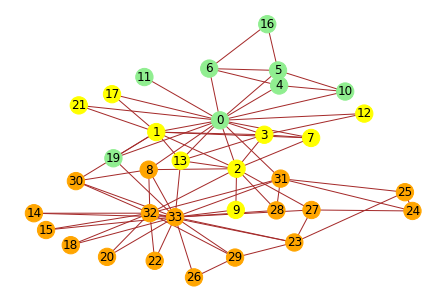

In [ ]:
colors = ['orange', 'yellow', 'lightgreen']

def get_color(label, communities):
    for index, community in enumerate(communities):
        if label in community:
            return colors[index]
    
nodes_color = [get_color(label, c) for label in G.nodes()]

nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=nodes_color, edge_color='brown', with_labels=True)

In [ ]:
print(f'Total Nodes: {len(G.nodes())}')
print(f'Total Edges: {len(G.edges())}')

Total Nodes: 34
Total Edges: 78


In [ ]:
baseline_communities = list(greedy_modularity_communities(G))
baseline = modularity(G, baseline_communities)
print(f'Modularity Baseline: {baseline}')

Modularity Baseline: 0.3806706114398422


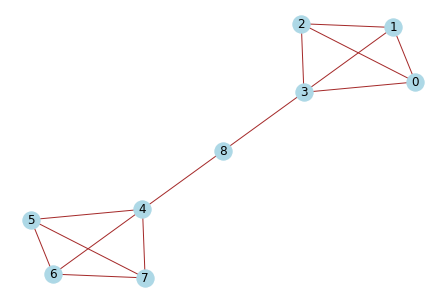

In [ ]:
G2 = nx.Graph()
[G2.add_node(node) for node in range(9)]
G2.add_edge(0, 1)
G2.add_edge(0, 2)
G2.add_edge(0, 3)
G2.add_edge(1, 2)
G2.add_edge(1, 3)
G2.add_edge(2, 3)

# G2.add_edge(3, 4)

G2.add_edge(4, 5)
G2.add_edge(4, 6)
G2.add_edge(4, 7)
G2.add_edge(5, 6)
G2.add_edge(5, 7)
G2.add_edge(6, 7)

G2.add_edge(3, 8)
G2.add_edge(4, 8)
# G2.add_edge(4, 9)
# G2.add_edge(8, 9)

nx.draw(G2, pos=nx.kamada_kawai_layout(G2), node_color='lightblue', edge_color='brown', with_labels=True)

In [ ]:
import random
import numpy as np
from networkx.algorithms.community.quality import modularity
from tqdm import tqdm_notebook

# lower frequencies for smaller ranges
class HybridBatAlgorithm:
    def __init__(self, graph, population_size, min_frequency, max_frequency, 
                 initial_loudness, alpha, initial_pulse_frequency, gamma,
                 num_iterations=10, seed=42):
        self.graph = graph
        self.random = random.Random(seed)
        np.seed = seed
        self.min_frequency = min_frequency
        self.max_frequency = max_frequency
        self.alpha = alpha
        self.initial_loudness = initial_loudness
        self.initial_pulse_frequency = initial_pulse_frequency
        self.gamma = gamma
        
        # locus-based adjacency representation
        self.valid_moves = {node:list(graph.neighbors(node)) for node in graph.nodes()}
#         print('valid_moves', valid_moves)
        
        self.bats = [Bat(self.graph, self.min_frequency, self.max_frequency, self.initial_loudness, self.initial_pulse_frequency, 
                         self.valid_moves , self.random) for _ in range(population_size)]
        self.num_iterations = num_iterations
        
    def find_current_best_bat(self):
        best_bat = None
        best_bat_fitness = -np.inf
        for bat in self.bats:
            if bat.fitness > best_bat_fitness:
                best_bat = bat
                best_bat_fitness = bat.fitness
                
        return best_bat
    
    def run(self):
        total_optimizations = 0
        best_bat = self.find_current_best_bat()
        print('best bat improved', best_bat.fitness)
        
        for iteration in tqdm_notebook(range(self.num_iterations)):
            old_best_bat = best_bat
            best_bat = self.find_current_best_bat()
            if best_bat.fitness > old_best_bat.fitness:
                print('best bat improved', best_bat.fitness)
    #         print('best_bat', best_bat.position)
            for bat_index, bat in enumerate(self.bats):
                newBat = bat.move(best_bat.position)
                self.bats[bat_index] = newBat if newBat.fitness > bat.fitness else bat # nao tem no algoritmo original
                newBat = self.bats[bat_index]
            
                if self.random.uniform(0, 1) > newBat.pulse_frequency:
                    F = 0.3 # [0.1, 1.0]
                    CR = 0.5 # [0.1, 1.0]
                    bat1, bat2, bat3 = np.random.choice(len(self.bats), 3, replace=False)
                    bat1, bat2, bat3 = self.bats[bat1], self.bats[bat2], self.bats[bat3]
                    trial_bat_position = bat1.position + F * (bat2.position - bat3.position)
#                     for bat_index, bat in enumerate(self.bats):
                    trial_bat_position = np.array([-1] * len(bat.position))
                    for j in range(len(trial_bat_position)):
                        jrand = random.randint(0, len(self.bats) - 1)
#                         print('j', j, 'jrand', jrand, trial_bat_position, bat.position)
                        if random.uniform(0, 1) <= CR or j == jrand:
                            trial_bat_position[j] = bat1.position[j] + F * (bat2.position[j] - bat3.position[j])
                        else:
                            trial_bat_position[j] = bat.position[j]

                    trial_bat = Bat(self.graph, self.min_frequency, self.max_frequency, 
                                    self.initial_loudness, self.initial_pulse_frequency, self.valid_moves, self.random)
                    trial_bat.set_position(trial_bat_position)
                    if trial_bat.fitness >= bat.fitness:
                        self.bats[bat_index] = trial_bat
            #             Select a solution among the best solutions
            #             Generate a local solution around the best solution

            newBat = Bat(self.graph, self.min_frequency, self.max_frequency, self.initial_loudness, self.initial_pulse_frequency, 
                         self.valid_moves , self.random)
            for bat_index, bat in enumerate(self.bats):
                if self.random.uniform(0, 1) < bat.loudness and bat.fitness < newBat.fitness:
                    newBat.total_optimizations += 1
                    self.bats[bat_index] = newBat
                    newBat.loudness *= self.alpha
                    newBat.pulse_frequency = self.initial_pulse_frequency * (1 - np.exp(-GAMMA * newBat.total_optimizations))
    
class Bat:
    def __init__(self, graph, min_frequency, max_frequency, initial_loudness, initial_pulse_frequency, valid_moves, random):
        self.graph = graph
        self.random = random
        self.min_frequency = min_frequency
        self.max_frequency = max_frequency
        
        self.valid_moves = valid_moves
        
        self.set_position(np.array([self.random.randint(0, len(value) - 1) for key, value in self.valid_moves.items()]))
        self.velocity = np.zeros(shape=self.position.shape)
        self.frequency = np.zeros(shape=self.position.shape)
        
        self.loudness = self.initial_loudness = initial_loudness
        self.pulse_frequency = self.initial_pulse_frequency = initial_pulse_frequency
        self.total_optimizations = 0
#         self.fitness = modularity(self.graph, self.decode_communities())

    def move(self, best_bat_position):        
#         print('old position', self.position)
        newBat = Bat(self.graph, self.min_frequency, self.max_frequency, self.initial_loudness, self.initial_pulse_frequency, 
                         self.valid_moves , self.random)
        newBat.frequency = self.min_frequency + (self.max_frequency - self.min_frequency) * self.random.uniform(0, 1)
        newBat.velocity = self.velocity + (best_bat_position - self.position) * newBat.frequency # INVERTIDO DO ALGORITMO. Afasta do ponto do melhor ao invés de aproximar (?)
        newBat.set_position(self.position + newBat.velocity.astype(int))
        return newBat
    
    def set_position(self, position):
        self.position = position
        self.repair_position_boundaries()
        self.fitness = modularity(self.graph, self.decode_communities())
        
    def repair_position_boundaries(self): # between 0 and len(graph.neighbors(node))
        self.position = np.maximum(self.position, np.zeros(shape=self.position.shape)).astype(int)
        self.position = np.minimum(self.position, [len(connections) - 1 
                                                           for node, connections in self.valid_moves.items()]).astype(int)
#         if not np.all(self.position == repaired_position):
#             print('velocity', self.velocity)
#             print('position', self.position)
#             print('repaired_position', repaired_position)
    
    def decode_communities(self):
        g = [self.valid_moves[node][connection] for node, connection in enumerate(self.position)]
        
        current_cluster = 1
        cluster_assign = [-1] * len(g)
        previous = [-1] * len(g)
#         print('--------------------------------------------------------------------------')
        for i in range(len(g)):
            ctr = 1
#             print('1 previous', previous, 'ctr', ctr, 'neighbor', g[i], 'cluster_assign', cluster_assign, 'g', g)
            if cluster_assign[i] == -1:
                cluster_assign[i] = current_cluster
                neighbor = g[i]
                previous[ctr] = i
                ctr += 1
                while cluster_assign[neighbor] == -1:
#                     if ctr < 0 or ctr >= len(previous):
#                     print('2 previous', previous, 'ctr', ctr, 'neighbor', neighbor, 'cluster_assign', cluster_assign, 'g', g)
                    previous[min(ctr, len(previous) - 1)] = neighbor
                    cluster_assign[neighbor] = current_cluster
                    neighbor = g[neighbor]
                    ctr += 1
                if cluster_assign[neighbor] != current_cluster:
                    ctr -= 1
                    while ctr >= 1:
#                         print('3 previous', previous, 'ctr', ctr, 'neighbor', neighbor,  'cluster_assign', cluster_assign, 'g', g)
                        cluster_assign[previous[ctr]] = cluster_assign[neighbor]
                        ctr -= 1
                else:
                    current_cluster += 1

        community_number = 1
        communities = []
#         print('current_cluster', current_cluster, 'cluster_assign', cluster_assign)
        for index, element in enumerate(cluster_assign):
            if element > len(communities):
                communities.append([])
            communities[element-1].append(index)
            
        return communities  

In [ ]:
POPULATION_SIZE = 40 # 10 to 250 - for most problems, 15 to 50 is sufficient - (original bat)
DIMENSION_SIZE = len(G.nodes())
NUM_ITERATIONS = DIMENSION_SIZE * 100
Q_MIN_FREQUENCY = 0
Q_MAX_FREQUENCY = 2
A_LOUDNESS = 0.5 # hybrid bat paper
ALPHA = 0.9 # (original bat paper) is similar to the cooling factor of a cooling schedule in the simulated annealing
R0_PULSE_FREQUENCY = 0.5 # hybrid bat paper
GAMMA = 0.9 # (original bat paper) 
OPTIMIZATION_COUNT = 0
SEED = 42

In [ ]:
test_valid_moves = {node:list(G2.neighbors(node)) for node in G2.nodes()}
rng = random.Random(SEED)
test = Bat(G2, Q_MIN_FREQUENCY, Q_MAX_FREQUENCY, A_LOUDNESS, R0_PULSE_FREQUENCY, 
                         test_valid_moves, rng)
print('set_position')
test.set_position(np.array([1, 2, 1, 3, 2, 1, 2, 1, 1]))
modularity(G2, test.decode_communities())

set_position


1.1102230246251565e-16

In [ ]:
hbat = HybridBatAlgorithm(graph=G, population_size=30, 
                          min_frequency=Q_MIN_FREQUENCY, max_frequency=Q_MAX_FREQUENCY, 
                          initial_loudness=A_LOUDNESS, alpha=ALPHA, 
                          initial_pulse_frequency=R0_PULSE_FREQUENCY, gamma=GAMMA,
                          num_iterations=20, seed=SEED)

# for bat in hbat.bats:
#     print(bat.position)
#     print(bat.fitness)

hbat.run()
# print('best position', hbat.find_current_best_bat().position)
# print('best velocity', hbat.find_current_best_bat().velocity)
print('**** best fitness', hbat.find_current_best_bat().fitness, end='\n\n')

best bat improved 0.37467126890203817


best bat improved 0.3906969099276791
best bat improved 0.3943951347797502
best bat improved 0.4151051939513477
best bat improved 0.41724194608809995
best bat improved 0.41740631163708086

**** best fitness 0.41978961209730437



In [ ]:
import community as community_louvain

partition = community_louvain.best_partition(G)
# print(partition)
community_number = 0
communities = []

for _ in range(max(partition.values()) + 1):
    communities.append([])

for index, element in partition.items():
    communities[element].append(index)

modularity(G, communities)

0.41880341880341876

3400


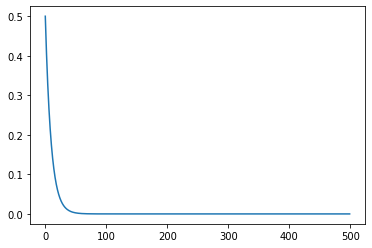

In [ ]:
print(NUM_ITERATIONS)
x = np.arange(NUM_ITERATIONS)
y = A_LOUDNESS*(ALPHA**x)

limit = 500
plt.plot(x[:limit], y[:limit])


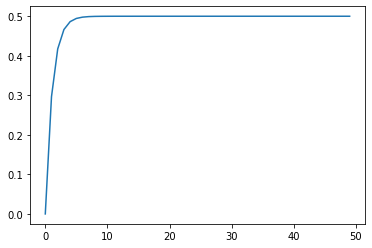

In [ ]:

R_PULSE_FREQUENCY = R0_PULSE_FREQUENCY * (1 - np.exp(-GAMMA*x))

limit = 50
plt.plot(x[:limit], R_PULSE_FREQUENCY[:limit])